# Preparation

In [1]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"
import numpy as np
import cv2

import google.colab for using drive file if it is necessary 

In [2]:
from google.colab import drive


drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Determine some necessary path

In [3]:
groundtruth_path = ""     # groundtruth location  "  #### -->  /trodo-v01/ground truth/groundtruth.json"
annotations_path = ""     # annotations location  "  #### -->  /trodo-v01/pascal voc 1.1/Annotations"
images_path = ""          # images location  "  #### -->  /trodo-v01/images"

Normalization image data

In [4]:
import json
import pandas as pd
import os

json_path = open(groundtruth_path)
json_data = json.load(json_path)
label_data = pd.json_normalize(json_data["odometers"])
label_data_droped_odometer_type = label_data.drop("odometer_type", axis = 1)

Defining some list and dictionaries

In [200]:
odometers_borders = []
analog_odometers_numbers_borders = {}
digital_odometers_numbers_borders = {}

Function check whether the variable is an integer or a string

In [201]:
def int_or_str(x):

  try:

    x = int(x)

  except ValueError:

    pass

  return x

 Function read xml file

In [202]:
import xml.etree.ElementTree as ET


def read_xml_file(xml_file: str):

    temp_list_1 = []
    temp_list_2 = []
    temp_list_3 = []

    tree = ET.parse(xml_file)
    root = tree.getroot()

    file_name = root.find('filename').text

    if label_data.loc[label_data["image"] == file_name, "odometer_type"].iloc[0] == "analog":

      for boxes in root.iter('object'):

          ymin, xmin, ymax, xmax, object_name = None, None, None, None, None

          ymin = float(boxes.find("bndbox/ymin").text)
          xmin = float(boxes.find("bndbox/xmin").text)
          ymax = float(boxes.find("bndbox/ymax").text)
          xmax = float(boxes.find("bndbox/xmax").text)


          if type(int_or_str(boxes.find("name").text)) == int:

            object_name = int_or_str(boxes.find("name").text)

            temp_list_1.append([(int(object_name)),(int(ymin), int(ymax), int(xmin), int(xmax))])


          elif int_or_str(boxes.find("name").text) == "odometer":

            odometers_borders.append([(file_name),(int(ymin), int(ymax), int(xmin), int(xmax))])


      for i in range(len(temp_list_1) - 1):
        for j in range(((len(temp_list_1) - 1) - i)):

          if temp_list_1[j][1][2] > temp_list_1[j+1][1][2]:

            temp_list_2 = temp_list_1[j+1]
            temp_list_1[j+1] = temp_list_1[j]
            temp_list_1[j] = temp_list_2



      for i in range(len(temp_list_1)):

        temp_list_3.append([(temp_list_1[i][0]),(temp_list_1[i][1][0], temp_list_1[i][1][1], temp_list_1[i][1][2], temp_list_1[i][1][3])])


      analog_odometers_numbers_borders.update({file_name: temp_list_3})


    elif label_data.loc[label_data["image"] == file_name, "odometer_type"].iloc[0] == "digital":

      for boxes in root.iter('object'):

        ymin, xmin, ymax, xmax, object_name = None, None, None, None, None

        ymin = float(boxes.find("bndbox/ymin").text)
        xmin = float(boxes.find("bndbox/xmin").text)
        ymax = float(boxes.find("bndbox/ymax").text)
        xmax = float(boxes.find("bndbox/xmax").text)

        if type(int_or_str(boxes.find("name").text)) == int:

          object_name = int_or_str(boxes.find("name").text)

          temp_list_1.append([(int(object_name)),(int(ymin), int(ymax), int(xmin), int(xmax))])


        elif int_or_str(boxes.find("name").text) == "odometer":

          odometers_borders.append([(file_name),(int(ymin), int(ymax), int(xmin), int(xmax))])



      for i in range(len(temp_list_1) - 1):
        for j in range(((len(temp_list_1) - 1) - i)):

          if temp_list_1[j][1][2] > temp_list_1[j+1][1][2]:

            temp_list_2 = temp_list_1[j+1]
            temp_list_1[j+1] = temp_list_1[j]
            temp_list_1[j] = temp_list_2



      for i in range(len(temp_list_1)):

        temp_list_3.append([(temp_list_1[i][0]),(temp_list_1[i][1][0], temp_list_1[i][1][1], temp_list_1[i][1][2], temp_list_1[i][1][3])])


      digital_odometers_numbers_borders.update({file_name: temp_list_3})

reading xml file

In [203]:
for xml_file_name in os.listdir(annotations_path):

  if ".xml" in xml_file_name:
    xml_file_path = f"{annotations_path}/{xml_file_name}"
    read_xml_file(xml_file_path)



# Analog Odometer Numbers Preparation

In [233]:
labels = []
features = []

Number is cropped from the images. Number images are resized and converted to grey.

In [234]:
for key in analog_odometers_numbers_borders.keys():

  features_temp = []
  labels_temp = []

  image_name = key
  image_path = f"{images_path}/{image_name}"

  for i in range(len(analog_odometers_numbers_borders.get(key))):

    image = cv2.imread(image_path)
    image = image[analog_odometers_numbers_borders.get(key)[i][1][0] : analog_odometers_numbers_borders.get(key)[i][1][1] ,
                  analog_odometers_numbers_borders.get(key)[i][1][2] : analog_odometers_numbers_borders.get(key)[i][1][3]]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (30, 40), interpolation = cv2.INTER_AREA)

    features_temp.append(image)
    labels_temp.append(analog_odometers_numbers_borders.get(key)[i][0])

  labels.append([(key),(labels_temp)])
  features.append([(key),(features_temp)])

In [235]:
len(features)

858

Display of images after processing

number = 0


(-0.5, 29.5, 39.5, -0.5)

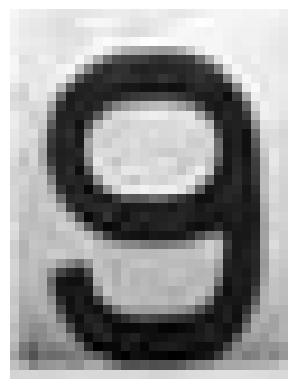

In [236]:
import matplotlib as mpl
import matplotlib.pyplot as plt


print(f"number = {labels[524][1][2]}")
plt.imshow(features[0][1][3], cmap=mpl.cm.binary)
plt.axis("off")

number = 7


(-0.5, 29.5, 39.5, -0.5)

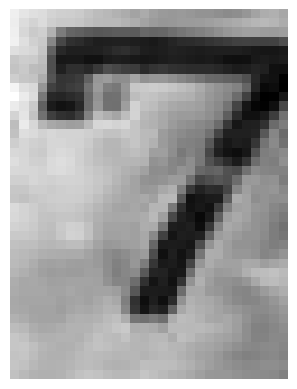

In [237]:
print(f"number = {labels[125][1][2]}")
plt.imshow(features[125][1][2], cmap=mpl.cm.binary)
plt.axis("off")

Lists are converted to numpy array

In [238]:
for i in range(len(features)):
  for j in range(len(features[i][1])):

    features[i][1][j] = np.asarray(features[i][1][j])


features are reshaped from 2D to 1D

In [239]:
for i in range(len(features)):
  for j in range(len(features[i][1])):

    x , y = features[i][1][j].shape
    features[i][1][j] = features[i][1][j].reshape(x*y)

In [240]:
x_train , x_test , y_train , y_test = [] , [] , [] , []

Splitting test and train set

In [241]:
for i in range(len(features[:int((858/100)*80)])):
  for j in range(len(features[i][1])):

    x_train.append(features[i][1][j])
    y_train.append(labels[i][1][j])

for i in range(len(features[int((858/100)*80):])):
  for j in range(len(features[int((858/100)*80):][i][1])):

    x_test.append(features[int((858/100)*80):][i][1][j])
    y_test.append(labels[int((858/100)*80):][i][1][j])

Lists are converted to numpy array

In [242]:
x_train = np.asarray(x_train)
x_test = np.asarray(x_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

# SVC MODEL

Some hyperparameters are determined to used GridSearch

In [277]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svc_gridsearch_parameters = {"gamma": ["scale"],
                             "C": [4, 7, 10, 20, 40],
                             "probability": [True],
                             "decision_function_shape": ["ovr"],
                             "random_state": [30, 25, 20, 15, 10]
                            }

Model is trained different parameters 25 time and for every trained model performs cross-validation 2 time.

In [278]:
SVC_gridsearch = GridSearchCV(SVC(), svc_gridsearch_parameters, verbose = 1, scoring = "roc_auc_ovr", cv = 2)

SVC_gridsearch.fit(x_train, y_train)

Fitting 2 folds for each of 25 candidates, totalling 50 fits


GridSearchCV(cv=2, estimator=SVC(),
             param_grid={'C': [4, 7, 10, 20, 40],
                         'decision_function_shape': ['ovr'], 'gamma': ['scale'],
                         'probability': [True],
                         'random_state': [30, 25, 20, 15, 10]},
             scoring='roc_auc_ovr', verbose=1)

Best parameters

In [279]:
SVC_gridsearch.best_params_

{'C': 7,
 'decision_function_shape': 'ovr',
 'gamma': 'scale',
 'probability': True,
 'random_state': 30}

In [280]:
SVC_MODEL = SVC_gridsearch.best_estimator_

In [281]:
SVC_MODEL.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Performance on the train set

In [303]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))

Prediction of model using cross-validation-prediction on the train set

In [304]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(SVC_MODEL, x_train_scaled, y_train, cv=2)

Confusion matrix

In [305]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_train, y_train_pred)
conf_matrix

array([[1449,    8,   12,    8,    4,    3,    6,    6,    3,    4],
       [  19,  479,   15,    5,   13,    1,    0,   22,    0,    1],
       [  32,    9,  334,   25,    5,    6,    6,   12,    6,    6],
       [  27,    9,   22,  277,    8,    8,    6,   14,   10,    9],
       [  14,   24,   15,    2,  297,    4,    3,    5,    6,    7],
       [  26,    3,    7,   14,    9,  220,   22,    5,   10,    2],
       [  35,    4,    4,    7,    6,   18,  206,    9,   17,    1],
       [  34,   27,   15,   11,    8,    3,    3,  273,    0,    1],
       [  25,   10,   13,   14,    2,    6,   38,    3,  160,   24],
       [  33,    4,   13,   10,    6,    3,    7,    3,   22,  157]])

In [306]:
conf_matrix_new = conf_matrix

Scaling confusion matrix to show clear

In [310]:
for i in range(len(conf_matrix_new)):

  temp = 0

  for j in range(len(conf_matrix_new)):

    temp = temp + conf_matrix_new[j][i]

  for j in range(len(conf_matrix_new)):

    conf_matrix_new[j][i] = int((conf_matrix_new[j][i] / temp)*1600)

Scaled confusion matrix

In [311]:
conf_matrix_new

array([[1371,   22,   42,   34,   17,   17,   32,   27,   20,   30],
       [  17, 1332,   53,   21,   58,    5,    0,  100,    0,    7],
       [  30,   24, 1189,  107,   22,   35,   32,   54,   41,   45],
       [  25,   24,   78, 1190,   35,   47,   32,   63,   68,   67],
       [  13,   66,   53,    8, 1331,   23,   16,   22,   41,   52],
       [  24,    8,   24,   60,   40, 1298,  118,   22,   68,   15],
       [  33,   11,   14,   30,   26,  105, 1111,   40,  116,    7],
       [  32,   74,   53,   47,   35,   17,   16, 1244,    0,    7],
       [  23,   27,   46,   60,    8,   35,  204,   13, 1095,  181],
       [  31,   11,   46,   42,   26,   17,   37,   13,  150, 1187]])

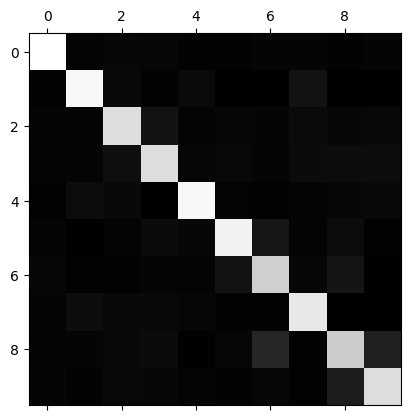

In [312]:
plt.matshow(conf_matrix_new, cmap=plt.cm.gray)
plt.show()

# Performance on the test set

In [314]:
scaler = StandardScaler()
x_test_scaled = scaler.fit_transform(x_test.astype(np.float64))

Prediction of model using cross-validation-prediction on the test set  

In [315]:
y_test_pred = cross_val_predict(SVC_MODEL, x_test_scaled, y_test, cv=2)

confusion matrix

In [316]:

conf_matrix = confusion_matrix(y_test, y_test_pred)
conf_matrix

array([[338,   1,   2,   7,   8,   0,   1,   1,   0,   2],
       [ 10,  80,   8,   2,  10,   4,   3,   0,   0,   0],
       [ 15,   2,  69,  19,   4,   1,   0,   3,   0,   0],
       [ 23,   1,   6,  52,   2,   3,   3,   1,   2,   3],
       [ 16,   3,   2,   5,  80,   2,   1,   1,   0,   0],
       [  3,   1,   2,   0,   2,  58,   7,   2,   1,   0],
       [ 10,   2,   0,   5,   2,   6,  51,   0,   3,   2],
       [  8,   3,   3,   9,   4,   1,   0,  46,   0,   0],
       [ 13,   0,   0,   7,   1,   2,  13,   0,  52,   1],
       [ 10,   1,   1,  11,   3,   2,   1,   0,   4,  40]])

In [317]:
conf_matrix_new = conf_matrix

Scaling confusion matrix to show clear

In [318]:
for i in range(len(conf_matrix_new)):

  temp = 0

  for j in range(len(conf_matrix_new)):

    temp = temp + conf_matrix_new[j][i]

  for j in range(len(conf_matrix_new)):

    conf_matrix_new[j][i] = int((conf_matrix_new[j][i] / temp)*500)

In [319]:
conf_matrix_new

array([[378,   5,  10,  29,  34,   0,   6,   9,   0,  20],
       [ 11, 425,  43,   8,  43,  25,  18,   0,   0,   0],
       [ 16,  10, 370,  81,  17,   6,   0,  27,   0,   0],
       [ 25,   5,  32, 222,   8,  18,  18,   9,  16,  31],
       [ 17,  15,  10,  21, 344,  12,   6,   9,   0,   0],
       [  3,   5,  10,   0,   8, 367,  43,  18,   8,   0],
       [ 11,  10,   0,  21,   8,  37, 318,   0,  24,  20],
       [  8,  15,  16,  38,  17,   6,   0, 425,   0,   0],
       [ 14,   0,   0,  29,   4,  12,  81,   0, 419,  10],
       [ 11,   5,   5,  47,  12,  12,   6,   0,  32, 416]])

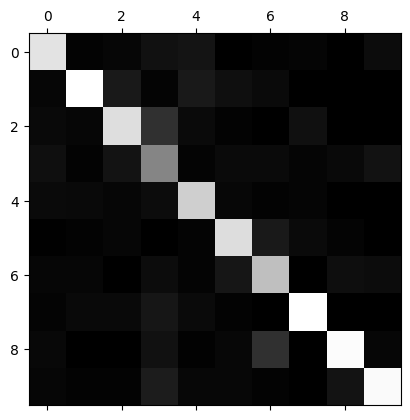

In [320]:
plt.matshow(conf_matrix_new, cmap=plt.cm.gray)
plt.show()

# Performance on the odometer

In [346]:
odometer_predict = []
y_true = []

Prediction of Model for every odometer

In [347]:
for i in range(len(features)):


  temp = 0
  temp_array = []
  temp_array = SVC_MODEL.predict(features[i][1])

  for j in range(len(temp_array)):

    temp = temp + (temp_array[j] * (pow(10,len(temp_array) - j)))

  odometer_predict.append(temp)
  y_true.append(int(label_data.loc[label_data["image"] == features[i][0], "mileage"].iloc[0]))

Accuracy

In [348]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true, odometer_predict)

0.0011655011655011655